The dataset consists of proeotmics from 5 bones + brain + meninges
1. skull (calvaria)
2. forearm (humerus)
3. vertebra
4. pelvis
5. femur
6. brain
7. meninges (not in naive)

for 3 conditions,
1. naive
2. sham (surgical cut)
3. mcao (stroke model)

for 3 animals each.

total 60 groups.


pooled samples have also scapula

sham meninges 3 has repeated measurement so replaced by sample 4

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random 

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ann

sc.settings.set_figure_params(dpi=100)


from utils import (
                    get_genes_per_group,                
                    filter_proteins_per_group, 
                    normalise,
                    impute_knn,
                    impute_knn_nan,
                    impute_min_value,
                    impute_min_value_nan,
                  )

from gprofiler import GProfiler
from gprofiler_plotting import plot_enrich, plot_gene_enrichment
from bioinfokit import analys, visuz
from upsetplot import plot, from_contents


In [3]:
DATA_DIR = ""
FILE_NAME = ""
delimiter = ""

In [4]:
data = pd.read_csv(f"{DATA_DIR}/{FILE_NAME}", delimiter=delimiter)

In [5]:
gene_column="Genes"

In [ ]:
# dropping genes with nan values
data = data[~data[gene_column].isna()]
data = data.reset_index()
data = data.drop(columns=["index"])

In [8]:
# specifying columns of interest
columns_naive = [col for col in data.columns if 'naive' in col]
columns_sham = [col for col in data.columns if 'sham' in col]
columns_mcao = [col for col in data.columns if 'mcao' in col]

columns_calvaria = [col for col in data.columns if 'calvaria' in col]
columns_meninges = [col for col in data.columns if 'meninges' in col]
columns_brain = [col for col in data.columns if 'brain' in col]

columns_humerus = [col for col in data.columns if 'humerus' in col]
columns_vertebra = [col for col in data.columns if 'vertebra' in col]
columns_pelvis = [col for col in data.columns if 'pelvis' in col]
columns_femur = [col for col in data.columns if 'femur' in col]

# remove scapula
COLUMNS = list(set(columns_naive + columns_sham + columns_mcao))
COLUMNS_BMS = list(set(COLUMNS) & (set(columns_calvaria + columns_meninges + columns_brain)))
COLUMNS_BONES = list(set(COLUMNS) - (set(columns_meninges + columns_brain)))

#### Number of protein detected

In [ ]:
df = pd.DataFrame()
regions = np.array([])
conditions = np.array([])
n_proteins = np.array([])
for c in COLUMNS:
    n = len(data) - data[c].isna().sum()
    regions = np.append(regions, c.split("_")[1].lower())
    conditions = np.append(conditions, c.split("_")[0])
    n_proteins = np.append(n_proteins, n)
df["region"] = regions
df["condition"] = conditions
df["number of proteins"] = n_proteins

In [11]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}

condition_to_color = {
    'MCAo'      : "#1f77b4",
    'Naive'     : "#ff7f0e",
    'Sham'      : "#279e68",
}

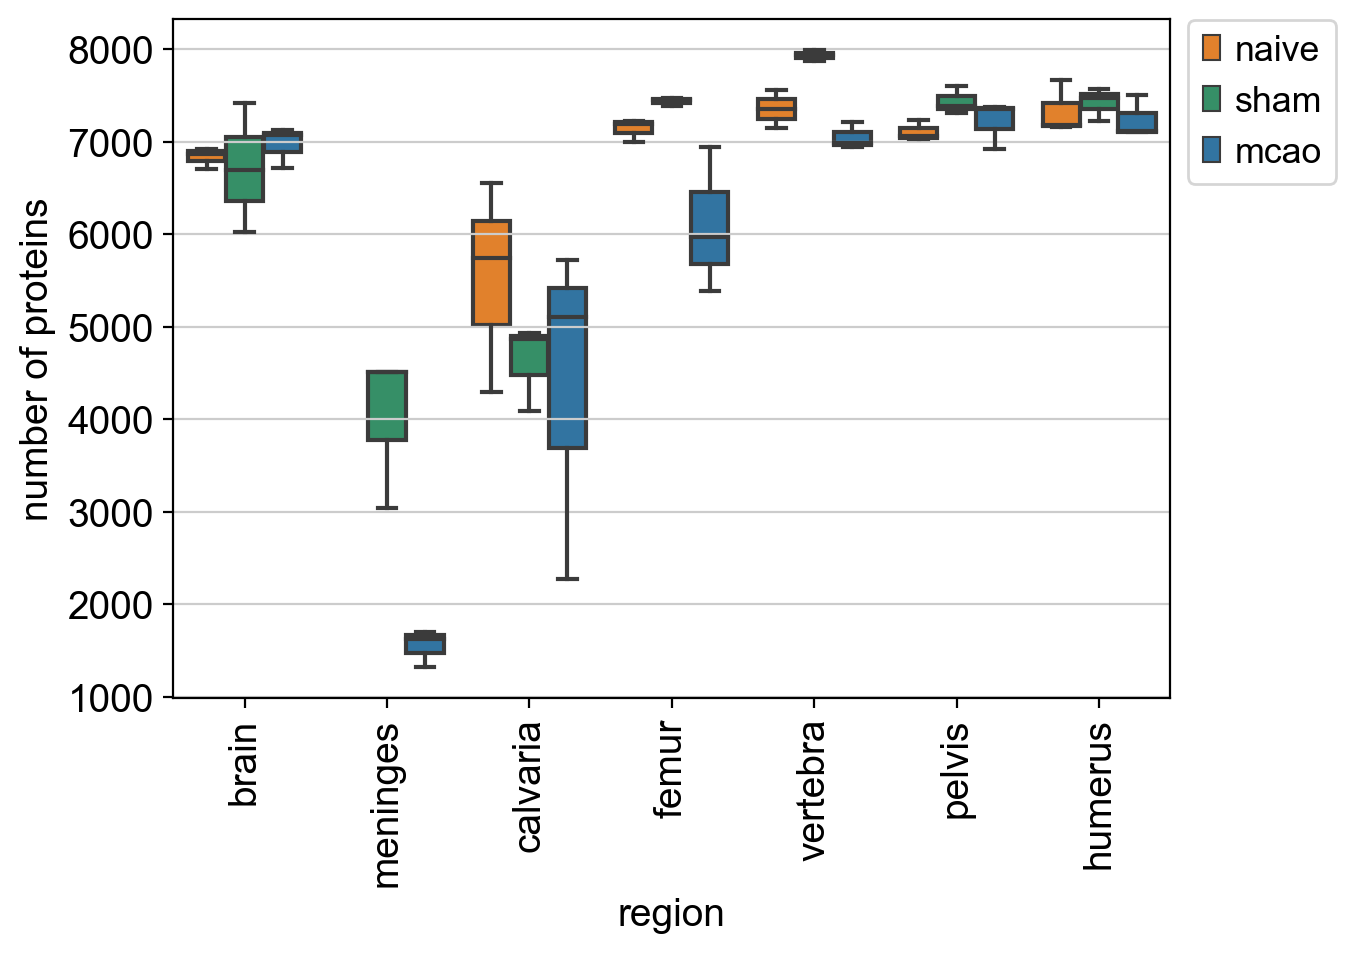

In [13]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df,
                x="region",
                y="number of proteins",
                hue="condition",
                hue_order=["naive", "sham", "mcao"],
                palette=[condition_to_color["Naive"], condition_to_color["Sham"], condition_to_color["MCAo"]],
                order=["brain", "meninges", "calvaria", "femur", "vertebra", "pelvis", "humerus"]
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1.025))
plt.tight_layout()

#### Upsetplots

In [14]:
# unique gene - available in all samples
## naive ##
genes_naive_calvaira = get_genes_per_group(data=data, 
                                           samples=list(set(columns_calvaria) & set(columns_naive)), 
                                           allow_na=True)
genes_naive_brain = get_genes_per_group(data=data, 
                                           samples=list(set(columns_brain) & set(columns_naive)), 
                                           allow_na=True)
genes_naive_pelvis = get_genes_per_group(data=data, 
                                           samples=list(set(columns_pelvis) & set(columns_naive)), 
                                           allow_na=True)
genes_naive_humerus = get_genes_per_group(data=data, 
                                           samples=list(set(columns_humerus) & set(columns_naive)), 
                                           allow_na=True)
genes_naive_vertebra = get_genes_per_group(data=data, 
                                           samples=list(set(columns_vertebra) & set(columns_naive)), 
                                           allow_na=True)
genes_naive_femur = get_genes_per_group(data=data, 
                                           samples=list(set(columns_femur) & set(columns_naive)), 
                                           allow_na=True)


## sham ##
genes_sham_calvaira = get_genes_per_group(data=data, 
                                           samples=list(set(columns_calvaria) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_brain = get_genes_per_group(data=data, 
                                           samples=list(set(columns_brain) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_meninges = get_genes_per_group(data=data, 
                                           samples=list(set(columns_meninges) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_pelvis = get_genes_per_group(data=data, 
                                           samples=list(set(columns_pelvis) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_humerus = get_genes_per_group(data=data, 
                                           samples=list(set(columns_humerus) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_vertebra = get_genes_per_group(data=data, 
                                           samples=list(set(columns_vertebra) & set(columns_sham)), 
                                           allow_na=True)
genes_sham_femur = get_genes_per_group(data=data, 
                                           samples=list(set(columns_femur) & set(columns_sham)), 
                                           allow_na=True)


## mcao ##
genes_mcao_calvaira = get_genes_per_group(data=data, 
                                           samples=list(set(columns_calvaria) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_brain = get_genes_per_group(data=data, 
                                           samples=list(set(columns_brain) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_meninges = get_genes_per_group(data=data, 
                                           samples=list(set(columns_meninges) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_pelvis = get_genes_per_group(data=data, 
                                           samples=list(set(columns_pelvis) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_humerus = get_genes_per_group(data=data, 
                                           samples=list(set(columns_humerus) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_vertebra = get_genes_per_group(data=data, 
                                           samples=list(set(columns_vertebra) & set(columns_mcao)), 
                                           allow_na=True)
genes_mcao_femur = get_genes_per_group(data=data, 
                                           samples=list(set(columns_femur) & set(columns_mcao)), 
                                           allow_na=True)


Before filtering - naive:


/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_35217/3985714405.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


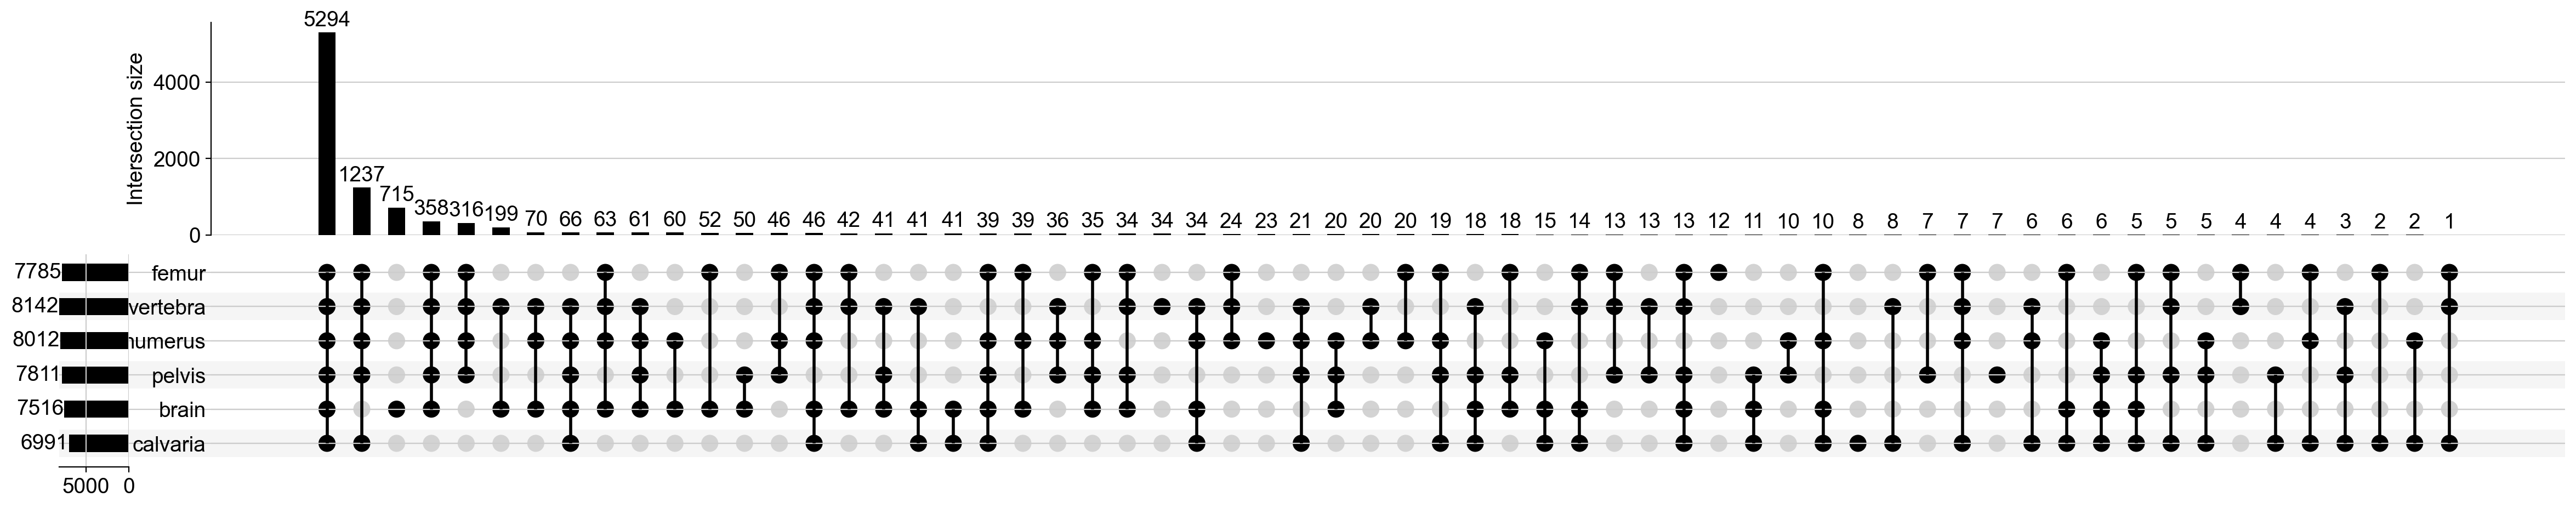

Before filtering - sham:


/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_35217/3985714405.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


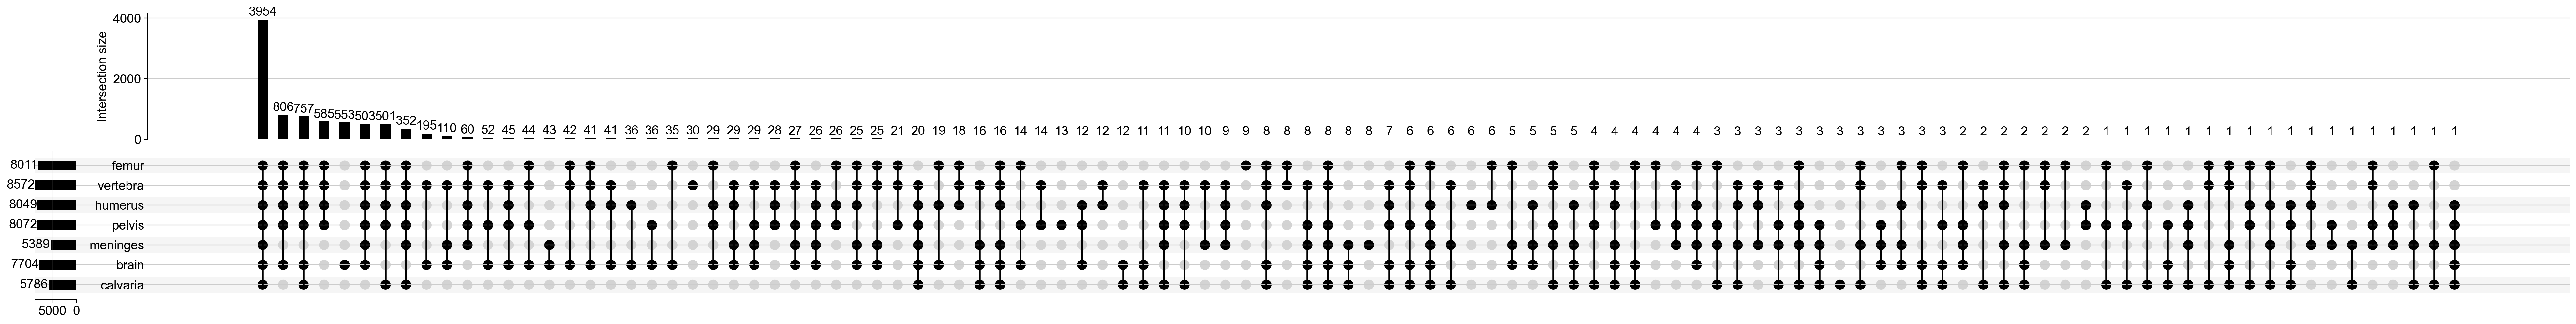

Before filtering - mcao:


/var/folders/v4/bvrmrlts5qb7pdsxz_52lkf1cjgg2l/T/ipykernel_35217/3985714405.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


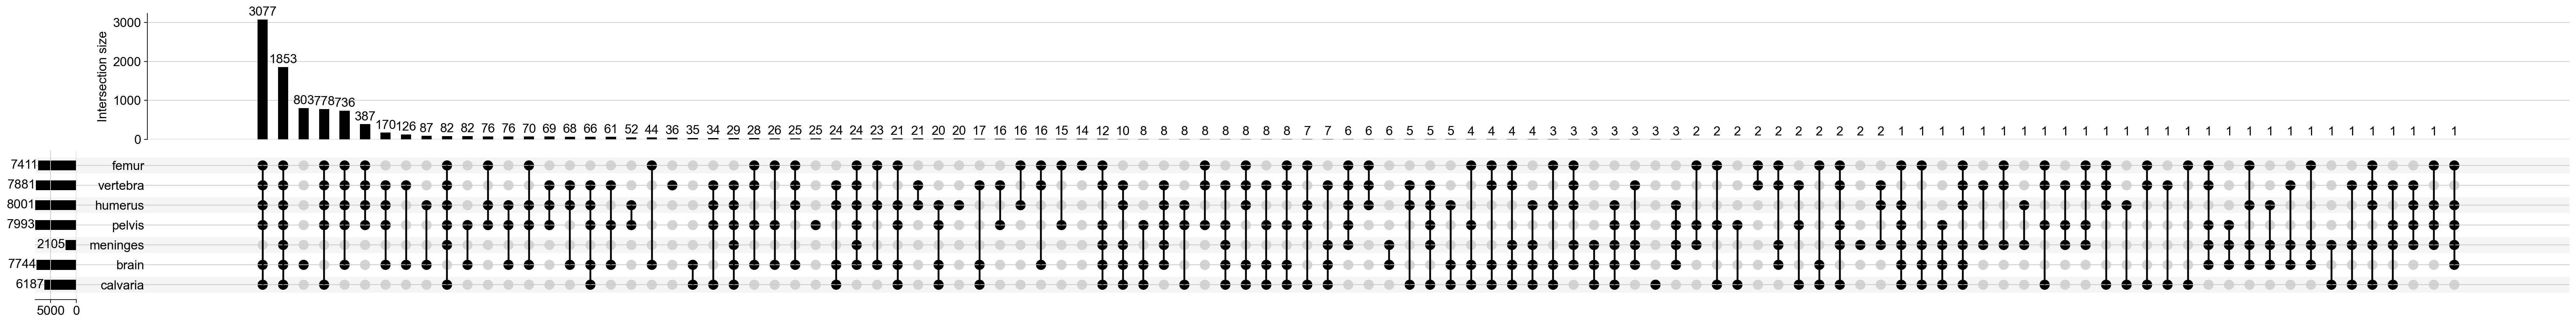

In [15]:
# plot upset plots
print('Before filtering - naive:')
contents = {
            'calvaria': genes_naive_calvaira,    
            'brain': genes_naive_brain,    
#             'meninges': genes_naive_meninges, 
            'pelvis': genes_naive_pelvis,  
            'humerus': genes_naive_humerus,
            'vertebra': genes_naive_vertebra,
            'femur': genes_naive_femur,
           }

plot(from_contents(contents), fig=plt.figure(figsize=(30,10)), 
     sort_categories_by=None, sort_by='cardinality', show_counts=True,
     orientation='horizontal'
    )
plt.tight_layout()
plt.show()



# plot upset plots
print('Before filtering - sham:')
contents = {
            'calvaria': genes_sham_calvaira,    
            'brain': genes_sham_brain,    
            'meninges': genes_sham_meninges, 
            'pelvis': genes_sham_pelvis,  
            'humerus': genes_sham_humerus,
            'vertebra': genes_sham_vertebra,
            'femur': genes_sham_femur,

           }

plot(from_contents(contents), fig=plt.figure(figsize=(30,10)), 
     sort_categories_by=None, sort_by='cardinality', show_counts=True,
     orientation='horizontal'
    )
plt.tight_layout()
plt.show()



# plot upset plots
print('Before filtering - mcao:')
contents = {
            'calvaria': genes_mcao_calvaira,    
            'brain': genes_mcao_brain,    
            'meninges': genes_mcao_meninges, 
            'pelvis': genes_mcao_pelvis,  
            'humerus': genes_mcao_humerus,
            'vertebra': genes_mcao_vertebra,
            'femur': genes_mcao_femur,

           }

plot(from_contents(contents), fig=plt.figure(figsize=(30,10)), 
     sort_categories_by=None, sort_by='cardinality', show_counts=True,
     orientation='horizontal'
    )
plt.tight_layout()
plt.show()